# 04. XGBoost

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
from sklearn import metrics
import graphviz
import joblib

## Read data

In [ ]:
base_path = "../data/processed/definitive-three-classes/"

train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")
real = pd.read_csv(base_path + "real.csv", dtype = {'FAM_Sample_info_id': str, 'VIC_Sample_info_id': str})

In [45]:
train['label'] = train['label'] * 2
test['label'] = test['label'] * 2
real['label'] = real['label'] * 2

In [46]:
train

,Shared_Markers,k0,k1,k2,Share_allele,Value,True_positive,Marcadores,Software,Datos,...,Value_range,FAM_Sample_info_id,FAM_Sample_info_rel,VIC_Sample_info_id,VIC_Sample_info_rel,ValueLog10,label,k1_scaled,k2_scaled,ValueLog10_scaled
0,12,3,4,8,20,1.0000,False,15,ScreenMatch,Simulados,...,0-99,63601,U,99702,U,0.000000,0.0,0.307692,0.666667,0.000000
1,13,2,8,5,18,2.0000,False,15,ScreenMatch,Simulados,...,0-99,4501,S,75801,S,0.301030,0.0,0.615385,0.416667,0.026637
2,12,3,4,8,20,34.8417,False,15,BlindSearch,Simulados,...,0-99,65402,U,77101,S,1.542099,0.0,0.307692,0.666667,0.136457
3,13,2,4,9,22,40.4718,False,15,BlindSearch,Simulados,...,0-99,13402,S,31502,U,1.607153,0.0,0.307692,0.750000,0.142213
4,14,1,8,6,20,1.0000,False,15,ScreenMatch,Simulados,...,0-99,2101,U,8002,U,0.000000,0.0,0.615385,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,13,2,4,9,22,6.0000,False,15,ScreenMatch,Simulados,...,0-99,59702,S,107002,S,0.778151,0.0,0.307692,0.750000,0.068857
702,13,2,8,5,18,10.0000,False,15,ScreenMatch,Simulados,...,0-99,88802,U,1702,S,1.000000,0.0,0.615385,0.416667,0.088488
703,12,3,5,7,19,2.0000,False,15,ScreenMatch,Simulados,...,0-99,31102,S,48302,S,0.301030,0.0,0.384615,0.583333,0.026637
704,12,3,6,6,18,1.0000,False,15,ScreenMatch,Simulados,...,0-99,149801,U,92902,U,0.000000,0.0,0.461538,0.500000,0.000000


In [47]:
# Declare feature and label columns
feature_columns = ["k1", "k2", "ValueLog10"]
label_columns = ["label"]

In [48]:
# Select feature and label columns
X_train = train[feature_columns]
y_train = train[label_columns]

X_test = test[feature_columns]
y_test = test[label_columns]

X_real = real[feature_columns]
y_real = real[label_columns]

## Train XGBoost

In [49]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

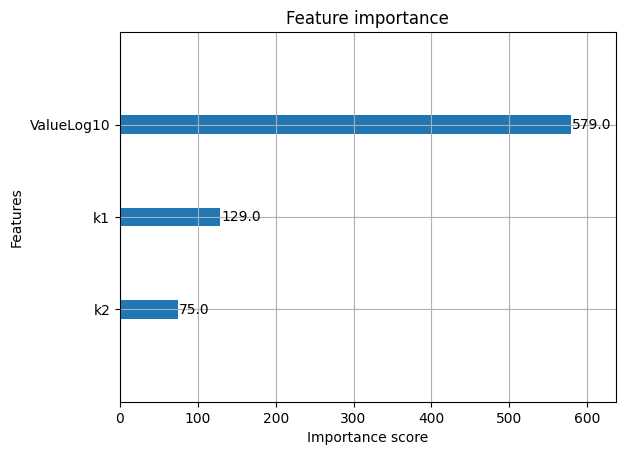

In [50]:
xgb.plot_importance(model)

In [51]:
model_importance = pd.DataFrame(list(model.get_booster().get_fscore().items()),
columns = ['feature','importance']).sort_values('importance', ascending = False)
print('', model_importance)

       feature  importance
2  ValueLog10       579.0
0          k1       129.0
1          k2        75.0


### Árbol de Ejemplo

In [52]:
xgb.plot_tree(model, tree_idx = 0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

### Mostrar una Proyección de la Función Aprendida por el Árbol

In [53]:
index_to_study = 500
proj_range = list(range(0, 20000))

df_range = pd.DataFrame(np.stack((X_train.iloc[index_to_study, :].values, ) * len(proj_range), axis = 0),
                        columns = X_train.columns)
df_range["ValueLog10"] = proj_range

Text(0, 0.5, 'Predicción')

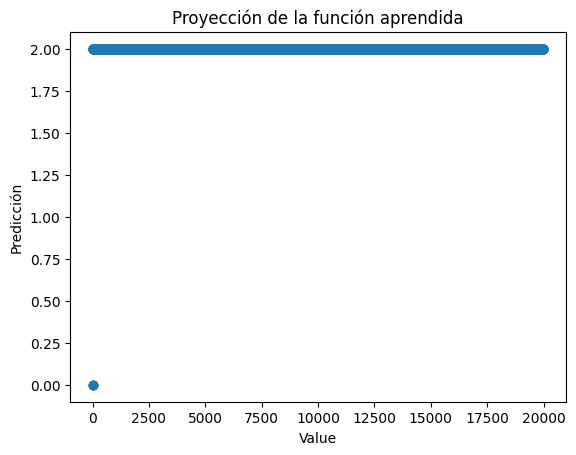

In [54]:
aux_out = model.predict(df_range)
plt.scatter(proj_range, aux_out)

plt.title("Proyección de la función aprendida")
plt.xlabel("Value")
plt.ylabel("Predicción")


### Evaluar la Capacidad de Aprendizaje

In [55]:
y_train_pred = model.predict(X_train)

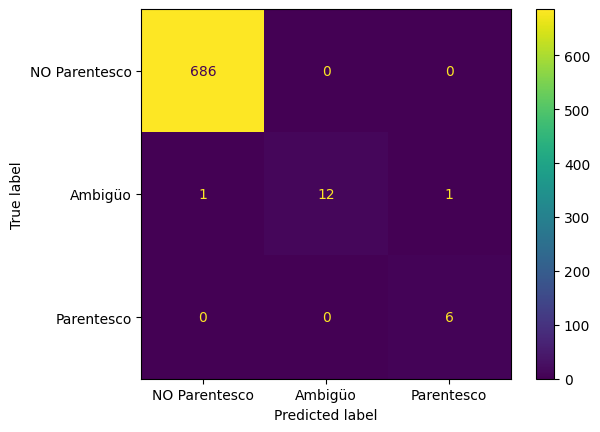

In [56]:
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['NO Parentesco', 'Ambigüo', 'Parentesco'])

cm_display.plot()
plt.show()

In [57]:
print(metrics.classification_report(y_train, y_train_pred, target_names = ['NO Parentesco', 'Ambigüo', 'Parentesco']))

               precision    recall  f1-score   support

NO Parentesco       1.00      1.00      1.00       686
      Ambigüo       1.00      0.86      0.92        14
   Parentesco       0.86      1.00      0.92         6

     accuracy                           1.00       706
    macro avg       0.95      0.95      0.95       706
 weighted avg       1.00      1.00      1.00       706



## Predict with XGBoost

In [58]:
y_pred = model.predict(X_test)

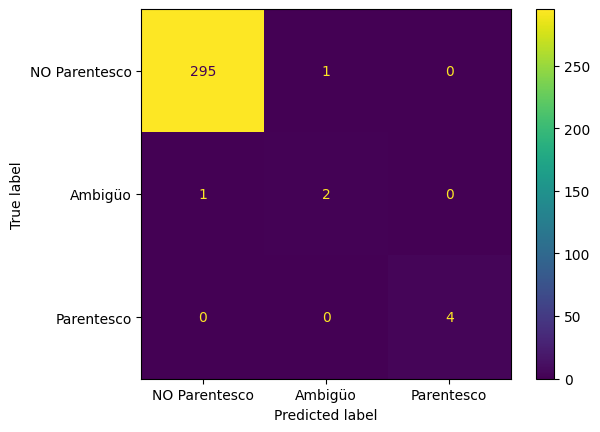

In [59]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['NO Parentesco', 'Ambigüo', 'Parentesco'])

cm_display.plot()
plt.show()

In [60]:
print(metrics.classification_report(y_test, y_pred, target_names = ['NO Parentesco', 'Ambigüo', 'Parentesco']))

               precision    recall  f1-score   support

NO Parentesco       1.00      1.00      1.00       296
      Ambigüo       0.67      0.67      0.67         3
   Parentesco       1.00      1.00      1.00         4

     accuracy                           0.99       303
    macro avg       0.89      0.89      0.89       303
 weighted avg       0.99      0.99      0.99       303



### Predict With Real Data

In [61]:
y_pred = model.predict(X_real)

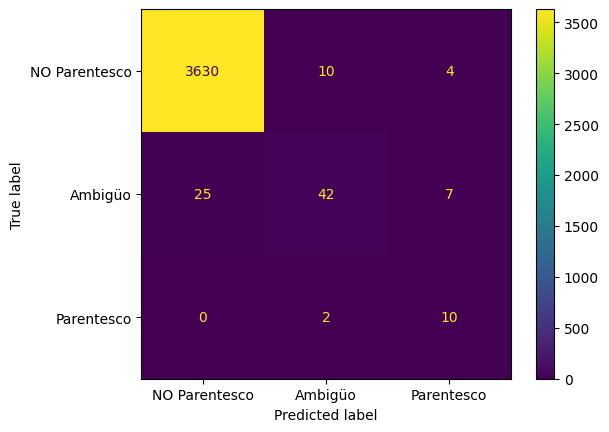

In [62]:
confusion_matrix = metrics.confusion_matrix(y_real, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['NO Parentesco', 'Ambigüo', 'Parentesco'])

cm_display.plot()
plt.show()

In [63]:
print(metrics.classification_report(y_real, y_pred, target_names = ['NO Parentesco', 'Ambigüo', 'Parentesco']))

               precision    recall  f1-score   support

NO Parentesco       0.99      1.00      0.99      3644
      Ambigüo       0.78      0.57      0.66        74
   Parentesco       0.48      0.83      0.61        12

     accuracy                           0.99      3730
    macro avg       0.75      0.80      0.75      3730
 weighted avg       0.99      0.99      0.99      3730



### Save Model

In [64]:
filename = '../models/xgboost-threeclass-v01.joblib'
joblib.dump(model, filename)

['../models/xgboost-threeclass-v01.joblib']

## Hyperparameter Tuning with Grid Search

In [65]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [66]:
def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [67]:
params = {
        'min_child_weight': [1, 3, 5],
        'max_depth': [2, 5, 10],
        'n_estimators': [100, 250, 500],
        'booster': ["gbtree", "gblinear", "dart"],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0]
        }

In [68]:
model = xgb.XGBClassifier(learning_rate = 0.005,
                          silent = True,
                          nthread = -1)

In [69]:
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 31)

grid_search = GridSearchCV(model, param_grid = params, scoring='roc_auc', n_jobs=4, cv = skf.split(X_train, y_train), verbose=3)

# Begin grid search
start_time = timer(None)
grid_search.fit(X_train, y_train)
timer(start_time)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


KeyboardInterrupt: 

In [ ]:
print('\n Best normalized gini score for %d-fold search.' % (folds))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('xgb-grid-search-results-01.csv', index=False)


 Best normalized gini score for 5-fold search.
0.9783068270320254

 Best hyperparameters:
{'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 500}


### Predict with the best model

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

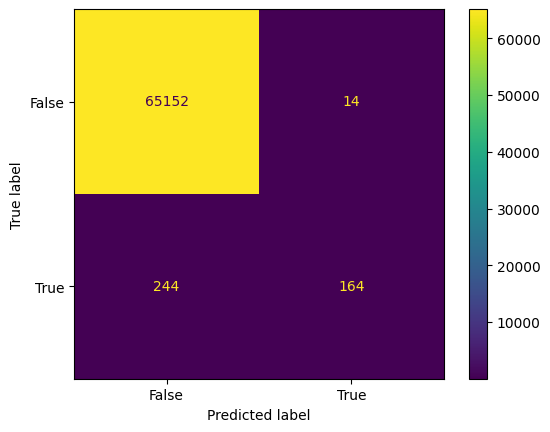

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['NO Parentesco', 'Ambigüo', 'Parentesco'])

cm_display.plot()
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names = ['NO Parentesco', 'Ambigüo', 'Parentesco']))

               precision    recall  f1-score   support

NO Parentesco       1.00      1.00      1.00     65166
   Parentesco       0.92      0.40      0.56       408

     accuracy                           1.00     65574
    macro avg       0.96      0.70      0.78     65574
 weighted avg       1.00      1.00      1.00     65574



### Save Model

In [ ]:
filename = '../models/xgboost-threeclass-OPv01.joblib'
joblib.dump(model, filename)